<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [2]:
from collections import defaultdict
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from utilities_functions import *

If u make a change to utilities_function u may need to restart the kernel to use the latest versions. This is too tedious. There must be another way.

In [45]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              BaggingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [46]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write an index with the content included in that section (see 'feature engineering' section if needed)
- Please write paragraphs before and after each cell that presents a new inisght. Do not assumer they are too obvious
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)


## Set-up

In [4]:
file_path ="../dataset/dynamic_dataset.csv"
df = pd.read_csv(file_path)

In [ ]:
df.head()

In [ ]:
#Dataset size
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

In [ ]:
#Column Names
print("\nColumn Names:")
print(df.columns.tolist())

In [ ]:
#Data Types
print("\nData Types:")
print(df.dtypes.value_counts())

In [ ]:
#General Info
df.info()

### Notebook-level constants

In [48]:
ONLY_NUMERICAL_COLUMNS = df.select_dtypes(include='number')
RANDOM_STATE = 99

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them

| Category | Feature Name | Description |
|----------|-------------|-------------|
| Memory | Memory_PssTotal | Total proportional set size (PSS) memory used by the process. |
| Memory | Memory_PssClean | Clean PSS memory that is not modified since it was loaded. |
| Memory | Memory_SharedDirty | Memory shared between processes that has been modified. |
| Memory | Memory_PrivateDirty | Memory allocated to the process that has been modified. |
| Memory | Memory_SharedClean | Shared memory that has not been modified. |
| Memory | Memory_PrivateClean | Private memory that has not been modified. |
| Memory | Memory_SwapPssDirty | Amount of swapped dirty memory. |
| Memory | Memory_HeapSize | Total heap memory allocated for the process. |
| Memory | Memory_HeapAlloc | Portion of heap memory currently in use. |
| Memory | Memory_HeapFree | Available heap memory not currently in use. |
| Memory | Memory_Views | Number of view objects in the process. |
| Memory | Memory_ViewRootImpl | Number of ViewRootImpl instances in the process. |
| Memory | Memory_AppContexts | Number of application context instances. |
| Memory | Memory_Activities | Number of active activities. |
| Memory | Memory_Assets | Number of asset allocations in memory. |
| Memory | Memory_AssetManagers | Number of AssetManager instances. |
| Memory | Memory_LocalBinders | Number of local binder objects. |
| Memory | Memory_ProxyBinders | Number of proxy binder objects. |
| Memory | Memory_ParcelMemory | Memory allocated for IPC parcels. |
| Memory | Memory_ParcelCount | Number of IPC parcels in use. |
| Memory | Memory_DeathRecipients | Number of registered death recipient callbacks. |
| Memory | Memory_OpenSSLSockets | Number of OpenSSL socket connections. |
| API | API_Process_android.os.Process_start | Starts a new process. |
| API | API_Process_android.app.ActivityManager_killBackgroundProcesses | Terminates background processes. |
| API | API_Process_android.os.Process_killProcess | Kills a specific process by its PID. |
| API | API_Command_java.lang.Runtime_exec | Executes a system command. |
| API | API_Command_java.lang.ProcessBuilder_start | Starts a new process using ProcessBuilder. |
| API | API_JavaNativeInterface_java.lang.Runtime_loadLibrary | Loads a native library. |
| API | API_JavaNativeInterface_java.lang.Runtime_load | Loads a dynamic library. |
| API | API_WebView_android.webkit.WebView_loadUrl | Loads a URL in WebView. |
| API | API_WebView_android.webkit.WebView_loadData | Loads raw HTML data in WebView. |
| API | API_WebView_android.webkit.WebView_loadDataWithBaseURL | Loads HTML data with a base URL. |
| API | API_WebView_android.webkit.WebView_addJavascriptInterface | Adds a JavaScript interface to WebView. |
| API | API_WebView_android.webkit.WebView_evaluateJavascript | Evaluates JavaScript in WebView. |
| API | API_WebView_android.webkit.WebView_postUrl | Posts data to a URL via WebView. |
| API | API_WebView_android.webkit.WebView_postWebMessage | Sends a web message via WebView. |
| API | API_WebView_android.webkit.WebView_savePassword | Saves login credentials in WebView. |
| API | API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword | Sets HTTP authentication credentials. |
| API | API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword | Retrieves saved HTTP authentication credentials. |
| API | API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled | Enables WebView debugging. |
| API | API_FileIO_libcore.io.IoBridge_open | Opens a file or socket. |
| API | API_FileIO_android.content.ContextWrapper_openFileInput | Opens a private file for reading. |
| API | API_FileIO_android.content.ContextWrapper_openFileOutput | Opens a private file for writing. |
| API | API_FileIO_android.content.ContextWrapper_deleteFile | Deletes a private file. |
| API | API_Database_android.content.ContextWrapper_openOrCreateDatabase | Opens or creates a database. |
| API | API_Database_android.content.ContextWrapper_databaseList | Lists databases in the app. |
| API | API_Database_android.content.ContextWrapper_deleteDatabase | Deletes a database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_execSQL | Executes a raw SQL query. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase | Deletes an SQLite database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_getPath | Retrieves the database file path. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_insert | Inserts a new record. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow | Inserts a record, throwing an exception on failure. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict | Inserts a record with conflict resolution. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_openDatabase | Opens an existing database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase | Opens or creates an SQLite database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_query | Executes a query on the database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory | Executes a query using a factory. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_rawQuery | Runs a raw SQL query. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory | Runs a raw query with a factory. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_update | Updates a database record. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict | Updates a record with conflict resolution. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_compileStatement | Compiles an SQL statement. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_create | Creates a new database. |
| API | API_IPC_android.content.ContextWrapper_sendBroadcast | Sends a broadcast message. |
| API | API_IPC_android.content.ContextWrapper_sendStickyBroadcast | Sends a sticky broadcast message. |
| API | API_IPC_android.content.ContextWrapper_startActivity | Starts an activity. |
| API | API_IPC_android.content.ContextWrapper_startService | Starts a service. |
| API | API_IPC_android.content.ContextWrapper_stopService | Stops a service. |
| API | API_IPC_android.content.ContextWrapper_registerReceiver | Registers a broadcast receiver. |
| API | API_Binder_android.app.ContextImpl_registerReceiver | Registers a receiver in the app context. |
| API | API_Binder_android.app.ActivityThread_handleReceiver | Handles broadcast receivers in ActivityThread. |
| API | API_Binder_android.app.Activity_startActivity | Starts an activity from another component. |
| API | API_Crypto_javax.crypto.spec.SecretKeySpec_$init | Initializes a secret key specification. |
| API | API_Crypto_javax.crypto.Cipher_doFinal | Performs encryption or decryption. |
| API | API_Crypto-Hash_java.security.MessageDigest_digest | Computes a cryptographic hash. |
| API | API_Crypto-Hash_java.security.MessageDigest_update | Updates a message digest with input data. |
| API | API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId | Retrieves the device ID. |
| API | API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId | Retrieves the subscriber ID. |
| API | API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number | Retrieves the device’s phone number. |
| API | API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator | Retrieves the network operator name. |
| API | API_DeviceInfo_android.net.wifi.WifiInfo_getMacAddress | Retrieves the device’s MAC address. |
| API | API_DeviceInfo_android.net.wifi.WifiInfo_getIpAddress | Retrieves the device’s IP address. |
| Network | Network_TotalReceivedBytes | Total bytes received over the network. |
| Network | Network_TotalReceivedPackets | Total network packets received. |
| Network | Network_TotalTransmittedBytes | Total bytes transmitted over the network. |
| Network | Network_TotalTransmittedPackets | Total network packets transmitted. |
| Battery | Battery_wakelock | Tracks wake lock usage. |
| Logcat | Logcat_verbose | Captures verbose log messages. |
| Logcat | Logcat_debug | Captures debug log messages. |
| Logcat | Logcat_info | Captures info log messages. |
| Logcat | Logcat_warning | Captures warning log messages. |
| Logcat | Logcat_error | Captures error log messages. |
| Process | Process_total | Tracks total active processes. |


### CONSTANTS SECTIONS

# 1. EDA

In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

## Data Type Distribution

In [ ]:
# Get the data type distribution
dtype_counts = df.dtypes.value_counts()
dtype_counts

We can see that most columns are numerical. Lets gets to see which are the variables that are of type object.

In [ ]:
df_onlyCols = df.select_dtypes(include=["object"]).columns
df_onlyCols

## Summary Statistics Overview

## Histograms


In [ ]:
# Select only numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot histograms
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

We can see most distributions tend to be right-skewed and only a small portion follows a normal distribution. This right-skewness will be dealt in feature-engineering.

In [ ]:
# Select only numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot boxplots
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])  # Boxplot for each feature
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Numerical Features

Seemed to be grouped by prefixes: Memory, Network, Battery, Logcat, Process y API.

According to dataset authors to capture how various malware families and categories behave at runtime, the analysis relies on six distinct sets of features obtained after executing each sample within a controlled emulated environment. These feature groups offer a comprehensive view of the malware's dynamic activity.

This categories appear before the first _ in every feature label and are defined as:


"Memory: Memory features define activities performed by malware by utilizing memory.

API: Application Programming Interface (API) features delineate the communication between two applications.

Network: Network features describe the data transmitted and received between other devices in the network. It indicates foreground and background network usage.

Battery: Battery features describe the access to battery wakelock and services by malware.

Logcat: Logcat features write log messages corresponding to a function performed by malware.

Process: Process features count the interaction of malware with total number of processes."



In [ ]:
numeric_cols = df.select_dtypes(include='number').columns

# Grouping based on the first prefix before "_"
prefix_groups = defaultdict(list)

for col in numeric_cols:
    prefix = col.split("_")[0]  # Get the first word before the underscore
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n {prefix} ({len(columns)} features):")
    for col in columns:
        print(f"  - {col}")

## Categorical Features

In [ ]:
#Statistical summary for categorical features
df.describe(include=["object", "category", "bool"])

In [ ]:
print(df[['Hash', 'Category', 'Family']].head())

Hash: unique identifier that represents each malware sample. <<<>>>THIS IS PROBABLY WRONG<<<>>>

Category: general classification of the malware sample based on its behavior.

Family: more fine-grained grouping of malware based on its codebase or origin

For hash, it will first be checked if the same malware before and after reboot contains the same hash value.

In [ ]:
# Count how many times each hash appears in 'before' and 'after'
hash_reboot_counts = df.groupby(['Hash', 'reboot']).size().unstack(fill_value=0)

# Hashes in both with exactly one in each
hashes_with_one_each = hash_reboot_counts[
    (hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1)
].index

# Hashes in both but with extra rows
hashes_in_both_but_not_clean = hash_reboot_counts[
    (hash_reboot_counts['before'] > 0) &
    (hash_reboot_counts['after'] > 0) &
    ~((hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1))
].index

# Total unique hashes
total_unique_hashes = df['Hash'].nunique()

# Hashes in only one reboot condition
hashes_in_one_condition = hash_reboot_counts[
    (hash_reboot_counts['before'] == 0) | (hash_reboot_counts['after'] == 0)
]

# Only once in one reboot condition
only_once_in_one = hashes_in_one_condition[
    (hashes_in_one_condition['before'] == 1) | (hashes_in_one_condition['after'] == 1)
]

# More than once in one reboot condition
more_than_once_in_one = hashes_in_one_condition[
    ((hashes_in_one_condition['before'] > 1) & (hashes_in_one_condition['after'] == 0)) |
    ((hashes_in_one_condition['after'] > 1) & (hashes_in_one_condition['before'] == 0))
]

# Split those into counts
more_than_once_in_before = more_than_once_in_one[more_than_once_in_one['before'] > 1]
more_than_once_in_after = more_than_once_in_one[more_than_once_in_one['after'] > 1]

# --- PRINT RESULTS ---
print(f"Hashes with EXACTLY one row in BOTH before and after: {len(hashes_with_one_each)}")
print(f"Hashes in BOTH, BUT with extra rows: {len(hashes_in_both_but_not_clean)}")

print(f"\nHashes in ONLY ONE reboot condition:")
print(f"• Appearing ONLY ONCE: {len(only_once_in_one)}")
print(f"• Appearing MORE THAN ONCE: {len(more_than_once_in_one)}")
print(f"   - More than once in BEFORE: {len(more_than_once_in_before)}")
print(f"   - More than once in AFTER: {len(more_than_once_in_after)}")

print(f"\nTotal breakdown:")
print(f"• In BOTH (any): {len(hashes_with_one_each) + len(hashes_in_both_but_not_clean)}")
print(f"• In ONLY ONE reboot: {len(hashes_in_one_condition)}")
print(f"• TOTAL unique hashes: {total_unique_hashes}")


A total of 19,169 hashes appear exactly once in both before and after conditions. These are highly reliable for paired  comparisons, ideal for understanding how reboot affects malware behavior.


There are 158 hashes that appear in both reboot states but not exactly once in each. These extra instances may come from inconsistencies in data capture like multiple logs for the same sample and should be checked.

A significant portion of samples appear only in one reboot condition. This is consistent with limitations described in the original dataset paper, where some malware samples failed to execute after the reboot. However, what is curious is that some still have been logged more than once.


In [ ]:
df = df.drop(columns=['Hash'])
'''
The Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.
It serves as an identifier for each malware sample. Including this column in modeling
would not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are
sensitive to high-cardinality categorical features.
 <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the 
  argumentation in a text cell not in this type of comments. <<<>>>
'''

This research will be using both Category and Family as the target variables for classification.

## Reboot Analysis

In [ ]:
print(df["reboot"].value_counts())

The imbalance observed in the dataset, with 28,380 samples collected before reboot and only 25,059 after reboot, is explained by limitations found during the dynamic analysis. The authors of the dataset note that "there was no entry point in some Android malware samples and some Android malware samples stopped abruptly." This means that certain malware applications either failed to launch or terminated unexpectedly during execution, preventing the collection of dynamic behavior data, particularly after the reboot phase.

Additionally, the study highlights another critical limitation: "the dynamic analysis is performed in an emulator. Some malware samples are able to detect the emulated environment and are not executed." This behavior reflects common anti-analysis techniques used by sophisticated malware, which can detect when they are running in a sandbox or emulator and intentionally suspend their malicious actions.




<<<>>>THIS ANALYSIS IS SUPER GOOD (you can delete this comment)<<<>>>

The displayed features are the top 10  most affected by reboot showing a clear reboot-sensitive behavior.

In [ ]:
#Category distribution across reboot
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Category', hue='reboot')
plt.title("Malware Categories by Reboot Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


To identify which numeric features are most influenced by the reboot condition, the dataset will be grouped by the reboot variable, separating entries collected before and after the device reboot. Within each group, the mean of every numeric feature will be computed, allowing for the comparison of average behavior across both states.

A new column labeled 'diff' was then added, representing the difference between the mean values after and before the reboot for each feature. A positive value indicates that the feature increased after reboot, while a negative value shows it decreased.

In [ ]:
reboot_means = df.groupby('reboot').mean(numeric_only=True).T
reboot_means['diff'] = reboot_means['after'] - reboot_means['before']
reboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)

reboot_means_sorted.head(10)

The results reveal that several features show clear shifts after reboot. Specially, network-related features such as Network_TotalReceivedBytes and Network_TotalTransmittedBytes demonstrate significant increases, suggesting that some malware types intensify data transmission once the device has rebooted. Memory features like Memory_SharedClean, Memory_HeapSize, and Memory_HeapAlloc also show increased values after reboot, indicating greater memory use or altered memory management after reboot.
This shows that the reboot condition plays an important role in runtime behavior and should be treated as an important factor in exploratory analysis and modeling.

## Missing Values

In [368]:
#AGREGAR LO DE NO_CATEGORY @Jon

In [ ]:
#Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False))

In [ ]:
print("Any missing values in the DataFrame:", df.isnull().values.any())

Although the dataset does not contain null values, this does not necessarily mean it is free of missing information. Placeholders are commonly used in place of missing, uncollected, or undetected values. These placeholders may take the form of strings like "<unknown>", "unknown", "UNK", or values such as "0", "-1", or "none" Despite they are not technically null they still represent incomplete data.

This hidden labels can have implications for data quality and model performance. If not properly identified and handled, these placeholder values can introduce noise or skew statistical summaries.

For textual placeholders:

In [ ]:
placeholders = ["<unknown>", "unknown", "UNKNOWN", "UNK", "?", "NA", "N/A", "-1", "0", "none", "null", "NULL"]

for value in placeholders:
    print(f"\nOccurrences of '{value}':")
    print((df == value).sum().sort_values(ascending=False))

<<<>>> I WOULD SUGGEST YOU DONT HARDCODE THE PLACEHOLDERS BUT ACTUALLY LOOK FOR THE DISTRIBUTION OF VALUES IN THE CATEGORICAL VARIABLES THAT MAY REPRESENT THIS. WE RISK SKIPPING SOME PLACEHOLDER THAT WAS NOT ANTICIPATED <<<>>>

In [ ]:
placeholders = ["<unknown>", "unknown", "UNK", "?", "NA", "N/A", "none", "null", "NULL"]

for value in placeholders:
    counts = (df == value).sum()

    filtered = counts[counts > 0].sort_values(ascending=False)

    if not filtered.empty:
        print(f"Occurrences of '{value}':")
        print(filtered)


Family feature contains placeholder for missing values: <<xx>unknown>

For numeric placeholders:

In [ ]:
numeric_placeholders = [-1, 9999, 0, 1]

for value in numeric_placeholders:
    counts = (df.select_dtypes(include="number") == value).sum()
    filtered = counts[counts > 0].sort_values(ascending=False)
    if not filtered.empty:
        print(f"\nNumeric placeholder occurrences: {value}")
        print(filtered)

A large number of features contain a value of 0 in every row, indicating that they offer no variability across the dataset. This may suggest that these features were never triggered during execution or were not properly captured due to limitations in the process. Regardless of the reason, such features provide no useful information for distinguishing between different malware categories and therefore do not contribute to predictive modeling.

Check for infinity or -inifity placeholders:

In [ ]:
has_inf = df.isin([np.inf, -np.inf]).any().any()
print("Contains inf:", has_inf)

In [ ]:
#Count duplicated values
df.duplicated().sum()

## DEALING WITH CLASS IMABLANCE

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="Category", order=df["Category"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Malware Categories")
plt.show()

The malware category distribution in the dataset is highly imbalanced, with a few classes (like Riskware, Adware, and Trojan) dominating the majority of samples.

This can lead to a situation where a classifier becomes biased toward the majority classes, achieving high overall accuracy but failing to correctly identify underrepresented malware types such as Trojan_Banker or FileInfector.

To address this, stratified sampling should be applied when splitting the dataset to preserve class proportions. During model training, techniques such as class weighting, SMOTE (Synthetic Minority Over-sampling Technique), ADASYN (Adaptive Synthetic Sampling), or under-sampling to balance the classes should be considered.

## Family

In [ ]:
#How many categories each family belongs to
df.groupby("Family")["Category"].nunique().sort_values(ascending=False)

Almost every family is either unknown or unique


In [378]:
# <<<Error: NameError: name 'family_to_category' is not defined>>>
# multi_cat_families = family_to_category[family_to_category > 1]
# print(f"Number of families mapping to multiple categories: {len(multi_cat_families)}")
# print(multi_cat_families)

There is only one Family that maps to multiple categories, and is the placeholder unknown.

The following code displays how many samples with unknown family labels belong to each malware category.

In [ ]:
df[df["Family"] == "<unknown>"]["Category"].value_counts()

In [ ]:
# Step 1: Count unique families per category
family_amount = df.groupby("Category")["Family"].nunique()

# Step 2: Total number of instances per category
total_per_category = df["Category"].value_counts()

# Step 3: Count how many of those are <unknown> per category
unknown_amount = df[df["Family"] == "<unknown>"]["Category"].value_counts()

# Step 4: Combine all stats into a summary table
summary_df = pd.DataFrame({
    "Family_amount": family_amount,
    "Total_category": total_per_category,
    "Unknown_amount": unknown_amount
}).fillna(0).astype({"Unknown_amount": int})

# Step 5: Calculate percentage of unknowns per category
summary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)

# Reorder columns for readability
summary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]

# Display the summary
print(summary_df)

In [ ]:
unknown_count = (df["Family"] == "<unknown>").sum()
print(f"Number of rows with Family == '<unknown>': {unknown_count}")


Based on the analysis of family distribution across categories:

The Adware category stands out with zero instances labeled as <unknown> and a balanced distribution across 43 families. This makes it a strong candidate for modeling.

In contrast, Zero_Day and No_Category The categories Zero_Day and No_Category exhibit extremely high family dispersion, with 2576 and 335 unique families. These values are significantly higher than all other categories, which generally have fewer than 50 families each.


This suggests they function more as placeholder labels. In particular, Zero_Day likely serves as a catch-all label for unknown or uncategorized threats, making it ambiguous. In cybersecurity, this term is refered to a new unknown vulnerability, not yet classified in terms of malware behavior, this is why samples are varied. They do not seem to represent a consistent type. On the other hand, No_Category explicitly denotes a lack of category. So, including these instances would only bring noise to the training process, preventing the model from learning meaningful patterns.
Therefore, they are excluded from the final dataset to preserve the quality and consistency of the classification task.


Additionally, categories like FileInfector show a high percentage of <unknown> families (6.85%) despite having a small total count, raising concerns about label quality. Most other categories maintain a relatively stable level of unknowns (around 3–5%), indicating that the presence of <unknown> is manageable.

# FEATURE ANALYSIS

INDEX OF CONTENT:
- Feature transformation
- Feature engineering
- Feature selection


### QUESTIONS
- How does feature hashing relate here?
- How can PCA be useful here? Should colinarity analysis be done before or after PCA?
- For right-skewness may this be useful?
- Is too much variance equally as bad as too low?

## FEATURE TRANSFORMATION

- Log transformation 
- Binning
- Interaction terms

### QUESTIONS
- We do have to do log-transformation before data-scaling, right? Or is that consider a feature scaling by itself?
- Where can we do binning here?
- Why is right-skweness bad? Why correcting it wont intrdocue any noise?

As we had anticipated before, many of the features' values distribution seem to have a heavy presence of right-skweness. Log-transfomration is the perfect solution for this

#### Log transformation
Let's start by detecting which are the right-skewed features

### Analysis

In [11]:
skwenessPerVariable = df.select_dtypes(include='number').skew()
skwenessPerVariable

Memory_PssTotal          3.442555
Memory_PssClean          1.183067
Memory_SharedDirty     157.421784
Memory_PrivateDirty      6.081789
Memory_SharedClean      -0.110135
                          ...    
Logcat_warning          18.503081
Logcat_debug            10.019481
Logcat_verbose          10.239173
Logcat_total           159.061274
Process_total            0.497408
Length: 141, dtype: float64

A normal distribution (perfectly symmetrically contains 0 skewness). Right skweness is positive, left skweness is negative. Lets show a brief example:

##### Maximum Right-skweness

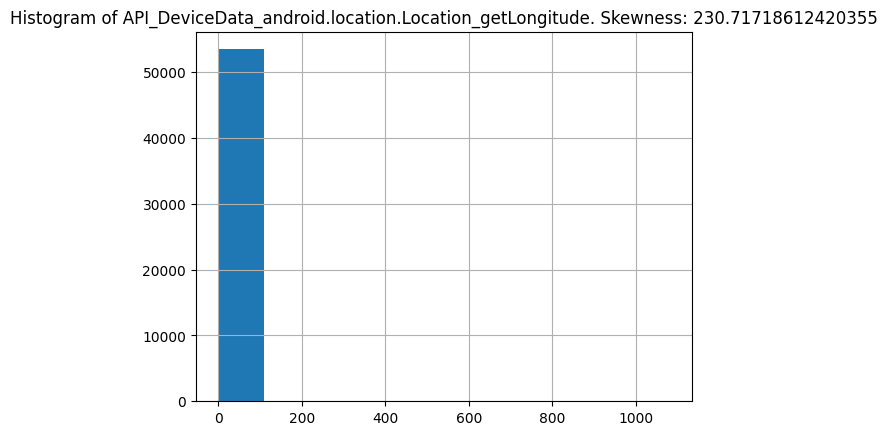

<Axes: xlabel='API_DeviceData_android.location.Location_getLongitude'>

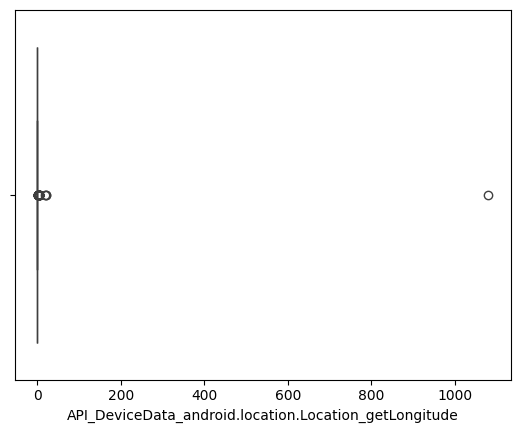

In [23]:
maximum_right_skewness = skwenessPerVariable.idxmax()
df[maximum_right_skewness].hist()
plt.title(f"Histogram of {maximum_right_skewness}. Skewness: {skwenessPerVariable[maximum_right_skewness]}")
plt.show()
sns.boxplot(x=df[maximum_right_skewness])

Some clear sings of right-skewness (mainly just due to the outlier)

##### Maximum Left-skweness

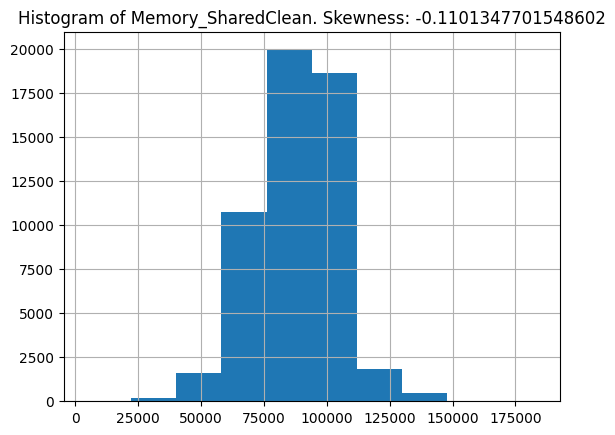

<Axes: xlabel='Memory_SharedClean'>

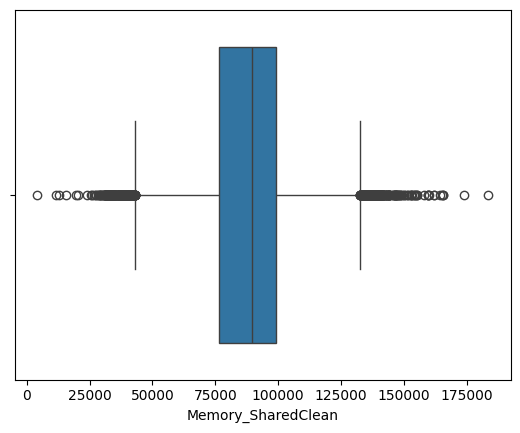

In [24]:
maximum_left_skewness = skwenessPerVariable.idxmin()
df[maximum_left_skewness].hist()
plt.title(f"Histogram of {maximum_left_skewness}. Skewness: {skwenessPerVariable[maximum_left_skewness]}")
plt.show()
sns.boxplot(x=df[maximum_left_skewness])

Barely any left-skweness.

Lets select all features with a significant degree of right-skewness. First, lets identify a reasonable threshold to mark right-skweded features and subsequently apply logarithimc scaling

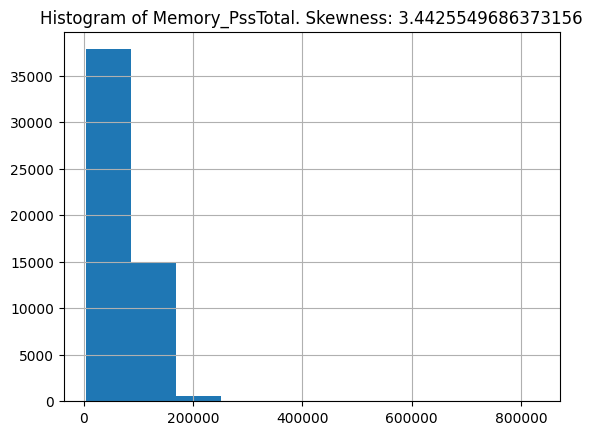

In [29]:
df["Memory_PssTotal"].hist()
plt.title(f"Histogram of Memory_PssTotal. Skewness: {skwenessPerVariable['Memory_PssTotal']}")
plt.show()

"Memory_PssTotal" contans 3.44 of skewness (third statistical moment). This already exhibits some degree of visual right-skweness, thus we will use it as a threshold.

In [31]:
RIGHT_SKWENESS_THRESHOLD = 3.44

In [34]:
right_skwed_variables = skwenessPerVariable[skwenessPerVariable > RIGHT_SKWENESS_THRESHOLD]
right_skwed_variables


Memory_PssTotal          3.442555
Memory_SharedDirty     157.421784
Memory_PrivateDirty      6.081789
Memory_HeapFree          5.562561
Memory_Views            64.773605
                          ...    
Logcat_error           201.526451
Logcat_warning          18.503081
Logcat_debug            10.019481
Logcat_verbose          10.239173
Logcat_total           159.061274
Length: 113, dtype: float64

Finally, lets apply the logarithmic transformation

In [35]:
#df[right_skwed_variables] = np.log(df[right_skwed_variables])



KeyError: "None of [Index([3.4425549686373156, 157.42178443270888,  6.081788927849094,\n        5.562560857572261,  64.77360511951933,   38.8520729779133,\n       38.376740432423375,  47.14989117138584, 23.176551582149475,\n         26.7391489404052,\n       ...\n       14.045825773470597, 13.975478544506059, 12.894951217462859,\n       14.090694934545326,  24.43398658865444, 201.52645146624778,\n       18.503081426156385, 10.019481175667789,  10.23917312448614,\n       159.06127449020306],\n      dtype='float64', length=113)] are in the [columns]"

### Applying logarithmic transformation

## FEATURE ENGINEERING
- Domain-specific features

NOTE: This requires further understanding of the concepts around our problem's context. This will be deferred for a second iteration.

## FEATURE SELECTION
- Analyze correlation and low-variances
- Remove low-predictive power variables


### > QUESTIONS
- Why is VIF being infinte in the study of multicolinearity?

#### 1.1) Eliminating low-variances features
We will start off feature selection by analyzing the variables that have low variances. Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset.

We will first analyze the distribution of the variances. We will not plot variances that are outliers in the distribution.

In [ ]:
numeric_cols = df.copy().select_dtypes(include='number')

variances = numeric_cols.var()

# Compute the first (Q1) and third quartiles (Q3)
Q1 = variances.quantile(0.25)
Q3 = variances.quantile(0.75)

IQR = Q3 - Q1

postiveOutliers = Q3 + 3 * IQR
negativeOutliers = Q1 - 3 * IQR

priorLength = len(variances)
cols_to_keep = variances[(variances <= postiveOutliers) & (variances >= negativeOutliers)].index
newLength = len(cols_to_keep)
print(f"Removed {priorLength - newLength} features with outliers of variance")

temp_df = numeric_cols[cols_to_keep]

In [ ]:
plt.hist(temp_df.var(), bins=30, edgecolor='black')
plt.title('Distribution of Variances for Numeric Features')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()


Lets dig deeper into the values around 0 so that we can select a better threshold for low-variance elimination

In [ ]:
df.shape

In [10]:
cols_to_keep = variances[(variances < 100)].index
temp_df = numeric_cols[cols_to_keep]

In [ ]:
basic_distribution_plot(temp_df.var(), 'Distribution of Variances for Numeric Features', 'Variance', 'Frequency', bins=30)

There seems to be a lot (almost 1/5) of features with very low variance. Our current selection for the variance threshold is going to be 1 unit of variance. 

In [12]:
MIN_SIGMA_THRESHOLD = 1

In [ ]:
originalCols = df.shape[1]
# Getting the variances of all features 
for col in list(df.select_dtypes(include='number').columns):
  colVariance = df[col].var()
  if colVariance < MIN_SIGMA_THRESHOLD:
    print(f">> Deleting '{col}' because of low variance: [{colVariance}]")
    df.drop(columns=[col], inplace=True)

newCols = df.shape[1]
print(f">> Deleted {originalCols - newCols} features with low variance")
    

As a quick side check we can also see that all columns have not constant values (as expected). This is critical for the analysis of multicolinearity via VIF.

In [ ]:
(df.nunique() < 1).sum()

#### 1.2) Eliminating highly correlated feature
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

In [ ]:
compute_correlation_matrix((17, 15), ONLY_NUMERICAL_COLUMNS)

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.

Well, thats a lot to digest! Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.

In [ ]:
vif_data = pd.DataFrame()
vif_data["Feature"] = ONLY_NUMERICAL_COLUMNS.columns
vif_data["VIF"] = [variance_inflation_factor(ONLY_NUMERICAL_COLUMNS.values, i) for i in range(ONLY_NUMERICAL_COLUMNS.shape[1])]
vif_data.sort_values(by="VIF", ascending=False)

In [ ]:
vif_data[vif_data["VIF"] >= 5].shape

In [ ]:
# Run this whenever u want to eliminate the correlated features 
# for correlated_feature in vif_data["Feature"]:
#   df.drop(columns=[correlated_feature], inplace=True)

In [49]:
# Lets check in the heatmap if we have any multicolinearity
corr_matrix = ONLY_NUMERICAL_COLUMNS.corr()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [51]:
# Find highly correlated feature pairs
high_corr_pairs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation"})
)

# Filter correlations above 0.65 or below -0.65
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > 0.7]
high_corr_pairs

Index(['Feature_1', 'Feature_2', 'Correlation'], dtype='object')

In [ ]:
# Run this whenever u want to eliminate the correlated features 
# for correlated_feature in high_corr_pairs["Feature_1"]:
#   df.drop(columns=[correlated_feature], inplace=True)


There seems to be some clear signs of correlation. However, for the first iteration we are going to be conservative and not remove them (for now; I want to further understand hows it possible for VIF to be inf). Note however, that some of the correlations show seem to make a lot of sense (e.g: Network_TotalReceivedBytes, Network_TotalTransmittedBytes)

#### 2.1) Eliminating low-predictive power variabes


As we have analyzed before 'Hash' is an approximation to a unique identifiers. This adds singificant noise to the model. Lets remove it 

In [7]:
df.drop(columns=["Hash"], inplace=True)

In [7]:
#df.drop(columns=["reboot"], inplace=True)  <<<>>> MAY GET DELETED, IF ANALYSIS INDICATES THIS IS MEANINGFUL

### Questions
- What other encoders could be useful?

# MODEL SELECTION

### QUESTION
- How can statistical measurement help on the split?
### TBD (to be done)
- 

## DATA SPLITTING

80% for training, 20% for hold-out sets (evenly distributed)

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

In [8]:
X_category, y_category = get_X_y(df, "Category", ["Family"])

Before we continue with the split, lets advance some for the time we get to the encoding process. 
We are gonna check how many categorical variables are present in each matrix

In [ ]:
X_category.select_dtypes(include=["object"])

In [ ]:
y_category

Also object!
Lets get back to the splitting!

In [9]:
X_category_train, X_category_val, X_category_test, y_category_train, y_category_val, y_category_test = get_split_data(X_category, y_category, train_size=0.8, validation_size=0.1, test_size=0.1, random_state=99)

X_category_train.shape, X_category_val.shape, X_category_test.shape, y_category_train.shape, y_category_val.shape, y_category_test.shape


((42751, 142), (5344, 142), (5344, 142), (42751,), (5344,), (5344,))

### Encoding

#### Encoding the X matrices (one-hot encoder)

Lets fit the X encoder for the object column (reboot)

In [10]:
X_category_train_encoded, X_category_val_encoded, X_category_test_encoded = get_X_sets_encoded(X_category_train, X_category_val, X_category_test)

Lets visualize the results of the encoding...

In [ ]:
X_category_train_encoded

In [ ]:
X_category_val_encoded

In [ ]:
X_category_test_encoded

Awesome, the X matrices are all set now. Lets finally encode the target variable (which we saw in the split process is of dtype: object)

#### Encoding y matrix (labeller encoding) 

In [ ]:
y_category_train

We know our models analyze the target variable in a numerical way. Lets transform this series then!

In [11]:
labeller = LabelEncoder()
labeller.fit(y_category_train)

LabelEncoder()

In [ ]:
y_category_train


In [12]:
y_category_train_encoded, y_category_val_encoded, y_category_test_encoded = get_y_sets_encoded(y_category_train, y_category_val, y_category_test)

One more time, let's visualize the results

In [13]:
y_category_train_encoded, "-"*30,  y_category_val_encoded, "-"*30, y_category_test_encoded, 

(48143     8
 10388     0
 11029     0
 36609     6
 26413    13
          ..
 42697    12
 36008     6
 46265     8
 23587     6
 29313     8
 Length: 42751, dtype: int64,
 '------------------------------',
 18288    6
 40648    6
 8718     0
 5961     0
 32688    8
         ..
 20920    6
 33656    3
 32607    8
 8923     0
 38099    6
 Length: 5344, dtype: int64,
 '------------------------------',
 28550    13
 43091    12
 8287      0
 47969     8
 29839     8
          ..
 53065     4
 49176     5
 30395     8
 4491      0
 2304      0
 Length: 5344, dtype: int64)

# MODELLING

## Automatic Feature Selection
Lets briefly extend our feature selection process:

### QUESTIONS
- Can this part not be done in feature engineering?
### TBD (things to be done)
- Read more about boruta

#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses.



In [14]:
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10)

In [ ]:
# Train logistic regression model with L1 penalty
model.fit(X_category_train_encoded, y_category_train_encoded)

# Get the coefficients of the trained model
coefficients = model.coef_
coefficients

In [ ]:
predictivePowerVariables = set()
for i in range(len(coefficients[0])):
      if abs(coefficients[0][i]) > 0:
            predictivePowerVariables.add(X_category_train_encoded.columns[i])
excludedVariables = set(X_category_train_encoded.columns) - predictivePowerVariables
predictivePowerVariables, "-"*30, f"Number of predictive power variables: {len(predictivePowerVariables)}", "-"*30, excludedVariables, "-"*30, f"Number of excluded variables: {len(excludedVariables)}"

#### BORUTA

In [15]:
rf = RandomForestClassifier(
    n_estimators=100,    
    n_jobs=-1, # multithreading
    class_weight='balanced',
    random_state=RANDOM_STATE
)

In [16]:
boruta_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=2,
    random_state=RANDOM_STATE,
    max_iter=10
)
# Fit Boruta on your training data.
boruta_selector.fit(X_category_train_encoded.values, y_category_train_encoded.values)
selected_mask = boruta_selector.support_

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	142
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	61
Tentative: 	12
Rejected: 	69
Iteration: 	9 / 10
Confirmed: 	61
Tentative: 	12
Rejected: 	69


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	61
Tentative: 	8
Rejected: 	73


In [18]:
selected_features = set(X_category_train_encoded.columns[selected_mask])
excludedVariables = set(X_category_train_encoded.columns) - selected_features
selected_features, "-"*30, f"Number of predictive power variables: {len(selected_features)}", "-"*30, excludedVariables, "-"*30, f"Number of excluded variables: {len(excludedVariables)}"

({'API_Base64_android.util.Base64_decode',
  'API_Binder_android.app.ActivityThread_handleReceiver',
  'API_Binder_android.app.Activity_startActivity',
  'API_Binder_android.app.ContextImpl_registerReceiver',
  'API_Command_java.lang.ProcessBuilder_start',
  'API_Command_java.lang.Runtime_exec',
  'API_Crypto-Hash_java.security.MessageDigest_digest',
  'API_Crypto-Hash_java.security.MessageDigest_update',
  'API_Crypto_javax.crypto.Cipher_doFinal',
  'API_Crypto_javax.crypto.spec.SecretKeySpec_$init',
  'API_DeviceData_android.content.ContentResolver_query',
  'API_DeviceData_android.content.ContentResolver_registerContentObserver',
  'API_DeviceData_android.os.SystemProperties_get',
  'API_DeviceInfo_android.net.wifi.WifiInfo_getIpAddress',
  'API_DeviceInfo_android.net.wifi.WifiInfo_getMacAddress',
  'API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId',
  'API_DeviceInfo_android.telephony.TelephonyManager_getNetworkCountryIso',
  'API_DeviceInfo_android.telephony.Telephony

Note: only execute the following cell if you want to use the results of boruta/L1 regularization:

In [34]:
eliminate_variables_from_set([X_category_train_encoded, X_category_val_encoded, X_category_test_encoded],
                              listOfVariables=excludedVariables)

No modifications were made to the set 0
No modifications were made to the set 1
No modifications were made to the set 2


Boruta said that only 61 variables were important, if that were the case the current dimensions for each set would have that nubmer

In [35]:
X_category_train_encoded.shape, X_category_val_encoded.shape, X_category_test_encoded.shape

((42751, 61), (5344, 61), (5344, 61))

Awesome, lets move on!

## Fitting the model

### TO BE DONE 
- Multiple models as classifiers
- Family as the target variable
- Other meaningful metrics (e.g: f1) (specially for multiclass!!!)

## Random Forest 
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster

## Non-optimized fitting

In [36]:
model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)

Lets fit the model

In [37]:
model.fit(X_category_train_encoded, y_category_train_encoded)

RandomForestClassifier(random_state=99)

Lets predict for both holdout sets (validation and testing)

In [44]:
y_val_pred = model.predict(X_category_val_encoded)
y_test_pred = model.predict(X_category_test_encoded)

Let's make sure the predictions vary between holdout sets

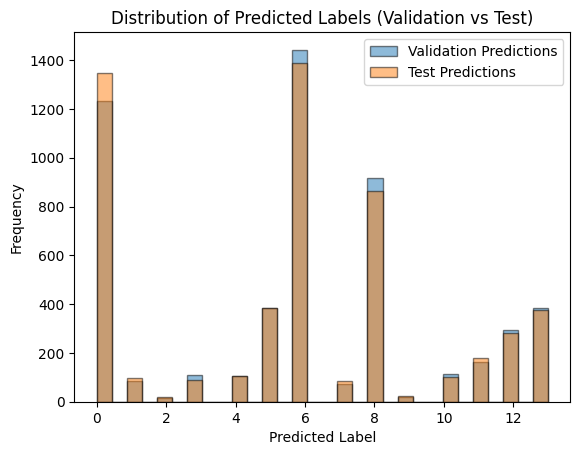

In [ ]:
plt.hist(y_val_pred, bins=30, edgecolor='black', alpha=0.5, label='Validation Predictions')
plt.hist(y_test_pred, bins=30, edgecolor='black', alpha=0.5, label='Test Predictions')

# Adding titles and labels
plt.title('Distribution of Predicted Labels (Validation vs Test)')
plt.xlabel('Predicted Label')
plt.ylabel('Frequency')

# Display the legend
plt.legend()

# Show the plot
plt.show()

### VALIDATION RESULTS

Validation Accuracy: 0.8325224550898204
Validation Classification Report:               precision    recall  f1-score   support

           0       0.76      0.94      0.84       996
           1       0.87      0.65      0.74       112
           2       1.00      0.68      0.81        25
           3       0.79      0.42      0.54       207
           4       0.90      0.77      0.83       122
           5       0.81      0.88      0.84       355
           6       0.88      0.90      0.89      1416
           7       0.85      0.84      0.85        75
           8       0.86      0.89      0.88       888
           9       0.81      0.63      0.71        27
          10       0.81      0.55      0.66       167
          11       0.86      0.71      0.78       198
          12       0.90      0.91      0.91       292
          13       0.75      0.62      0.68       464

    accuracy                           0.83      5344
   macro avg       0.85      0.74      0.78      5344
weight

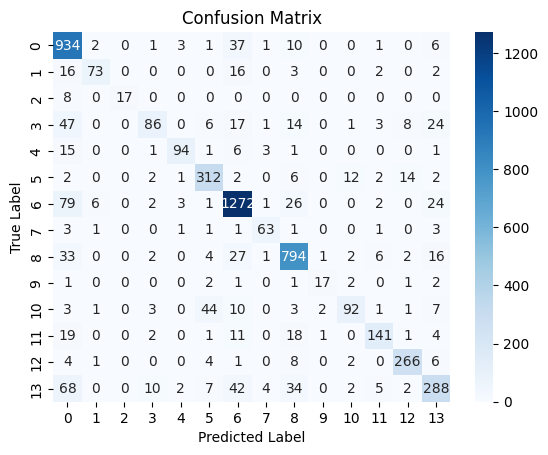

In [ ]:
val_acc, val_class_report, val_confusion_matrix = evaluate_classifier(y_category_val_encoded, y_val_pred, display_results=True, plot_confusion_matrix=True)

### TEST RESULTS

Validation Accuracy: 0.8340194610778443
Validation Classification Report:               precision    recall  f1-score   support

           0       0.78      0.94      0.85      1116
           1       0.82      0.70      0.75       115
           2       0.89      0.63      0.74        27
           3       0.81      0.39      0.53       189
           4       0.92      0.77      0.84       126
           5       0.80      0.88      0.84       350
           6       0.89      0.90      0.89      1364
           7       0.87      0.85      0.86        88
           8       0.85      0.90      0.87       810
           9       0.83      0.61      0.70        33
          10       0.81      0.50      0.62       167
          11       0.87      0.76      0.81       208
          12       0.89      0.88      0.89       286
          13       0.76      0.61      0.68       465

    accuracy                           0.83      5344
   macro avg       0.84      0.74      0.78      5344
weight

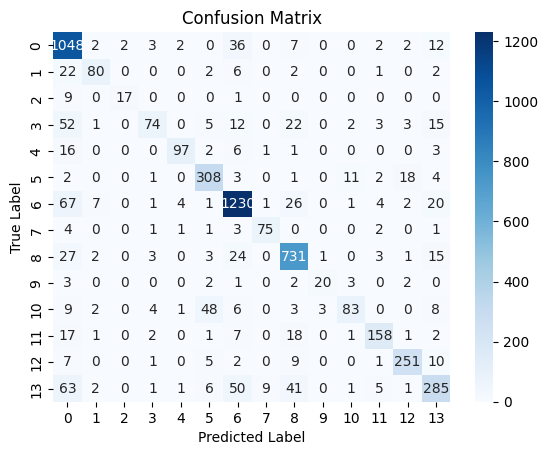

In [ ]:
test_acc, test_class_report, test_confusion_matrix = evaluate_classifier(y_category_test_encoded, y_test_pred, display_results=True, plot_confusion_matrix=True)

## Optimizing with grid-search

Note 1: the following cells took 11mins to run in an M2
Note 2: grid-search is not a good choice for optimization (enough for an early iteration, tough). We need to get smarter using more advanced techniques (e.g: OPTUNA)

In [ ]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_category_train_encoded, y_category_train_encoded)

# Best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

In [ ]:
best_model.fit(X_category_train_encoded, y_category_train_encoded)
y_val_pred = best_model.predict(X_category_val_encoded)
y_test_pred = best_model.predict(X_category_test_encoded)


In [ ]:
evaluate_classifier(y_category_val_encoded, y_val_pred, display_results=True, plot_confusion_matrix=True)
evaluate_classifier(y_category_test_encoded, y_test_pred, display_results=True, plot_confusion_matrix=True)

## NOTEBOOK, AREAS FOR IMPROVEMENTS
<ul> Introducing as many ML algorithms for non-predictive tasks: 
       <li> Data imputing with KNN </li>
       <li> Cluster analysis to better understand the features </li>
       <li> Doing PCA for features (after correlation analysis) </li>
</ul>
- Distilled models
- DevOPs pipeline design